## Load Libraries

In [ ]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 1.4 MB/s 


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 30.5 MB/s 


In [ ]:
#import libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import efficientnet_b0
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from torchmetrics.functional import pairwise_manhattan_distance
import matplotlib.pyplot as plt
from statistics import mean
from scipy.spatial import distance

## Prepare Dataset

In [ ]:
#load the omniglot dataset from torchvision and preprocess
image_size = 28

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


In [ ]:
#set required params
training_episodes = 1500
val_episodes = 1500
test_episodes = 1500
n_way = 5
n_shot = 5
n_query_img = 5
num_workers = 2
epochs = 4

Prepare a custom dataloader that separately creates a support and query set along with labels, to be loaded by episodes and not epochs

In [ ]:
#prepare custom dataloaders with easyfsl library

# Train Dataloader
train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(train_set, n_way=n_way, n_shot=n_shot, n_query=n_query_img, n_tasks=training_episodes)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

#Test Dataloader
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(test_set, n_way=n_way, n_shot=n_shot, n_query=n_query_img, n_tasks=test_episodes)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

## Prepare Model

using pretrained efficientnet in the backbone as a feature extractor before calculating prototypes in the embedding space

In [ ]:
feature_extractor = efficientnet_b0(pretrained=True)
feature_extractor.fc = nn.Flatten()
print(feature_extractor)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# ProtoNet custom class to calculate prototypes and manhattan distance of query images from the prototypes
class ProtoNet(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(ProtoNet, self).__init__()
        self.backbone = backbone

    def forward(self,support_images,support_labels,query_images):
        # map support images into an embedding space
        emb_support = self.backbone.forward(support_images)
        emb_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))

        # calculate prototype per class
        prototype = torch.cat([emb_support[torch.nonzero(support_labels == label)].mean(0)for label in range(n_way)])
        # Compute the manhattan distance from queries to prototypes
        dists = pairwise_manhattan_distance(emb_query, prototype)
        scores = -dists
        return scores

model = ProtoNet(feature_extractor).cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training and Evaluation

In [ ]:
#function to perform inference on one single episode or task
def evaluate_on_one_task(support_images,support_labels,query_images,query_labels):
    total_predictions = len(query_labels)
    result = model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
    correct_indices =torch.max(result.detach().data,1,)[1]
    correct_predictions = (correct_indices== query_labels.cuda()).sum().item()
    
    return correct_predictions,total_predictions

In [ ]:
#code to run training on the number of episodes
losslist = []
acclist = []
epoch_losslist = []
best_acc = 0
for epoch in range(epochs):
  model.train()
  with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
      for episode_index, (support_images,support_labels,query_images,query_labels,_,) in tqdm_train:
          optimizer.zero_grad()
          output = model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
          loss = criterion(output, query_labels.cuda())
          loss.backward()
          optimizer.step()
          final_loss = loss.item()
          losslist.append(final_loss)

  print('epoch:',epoch, 'mean loss of episodes:',mean(losslist))
  epoch_losslist.append(mean(losslist))

  
  total_predictions = 0
  correct_predictions = 0
  model.eval()
  with torch.no_grad():
      for episode_index, (support_images,support_labels,query_images,query_labels,class_ids,) in tqdm(enumerate(test_loader), total=len(test_loader)):

          correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
          total_predictions += total
          correct_predictions += correct
          val_acc = (correct_predictions/total_predictions)*100
          acclist.append(val_acc)
          if val_acc>best_acc:
            best_acc = val_acc
  print('val accuracy:',val_acc)


100%|██████████| 1500/1500 [02:57<00:00,  8.47it/s]


epoch: 0 mean loss of episodes: 13.233010382334392


100%|██████████| 1500/1500 [01:09<00:00, 21.67it/s]

val accuracy: 75.6



100%|██████████| 1500/1500 [02:49<00:00,  8.85it/s]

epoch: 1 mean loss of episodes: 9.445202419936656



100%|██████████| 1500/1500 [01:10<00:00, 21.37it/s]

val accuracy: 87.06933333333333



100%|██████████| 1500/1500 [02:46<00:00,  9.00it/s]

epoch: 2 mean loss of episodes: 8.138311236951086



100%|██████████| 1500/1500 [01:08<00:00, 21.76it/s]

val accuracy: 73.18666666666667



100%|██████████| 1500/1500 [02:46<00:00,  9.01it/s]

epoch: 3 mean loss of episodes: 7.4990043579439325



100%|██████████| 1500/1500 [01:07<00:00, 22.17it/s]

val accuracy: 75.41333333333333


In [ ]:
print('Best Accuracy is:', best_acc)

Best Accuracy is: 88.0


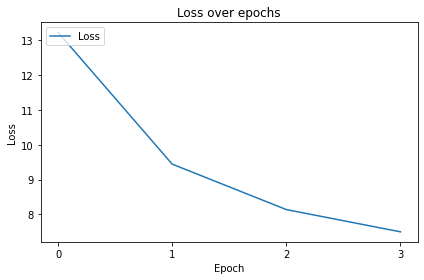

In [ ]:
# plot graph of train and val loss vs epochs
plt.rcParams["figure.autolayout"] = True
plt.plot(epoch_losslist)
plt.xticks(range(0,4))
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()